# Model (ResNet) - Binary

Within this model, we'll use the same VGG16 model, but reduce the options down to 'Subuaru' and 'Not Subaru'

### Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle
import time
import os
import json
import seaborn as sns
import tensorflow as tf
import random
import cv2

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential

from keras.applications import VGG16
from keras.applications.resnet import ResNet152
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array



from pandas import json_normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score,classification_report
from sklearn.preprocessing import normalize,StandardScaler,RobustScaler,MinMaxScaler
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.compose import ColumnTransformer


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D,LeakyReLU
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist, cifar10

from tensorflow import keras
from keras.utils import to_categorical
from keras import regularizers
from keras.models import load_model
from keras.layers import GlobalAveragePooling2D





from scipy.stats import skew

from PIL import Image

### Data Augmentation

In [ ]:
# Remove comment to run again
# datagen = ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     vertical_flip=False,
#     fill_mode='nearest'
# )

In [ ]:
# Remove comment to run again
# image_dir = "Datasets/VMMRdb/"

for root, dirs, files in os.walk(image_dir):
    for filename in files:
        if not filename.startswith('.'):
            # check if the file starts with 'subaru'
            if filename.startswith('subaru'):
                filepath = os.path.join(root, filename)
                # load the image and convert it to a numpy array
                img = load_img(filepath)
                img_array = img_to_array(img)
                # reshape the array to have an extra dimension
                img_array = img_array.reshape((1,) + img_array.shape)
                # generate X (in range) augmented images and save them
                for i in range(4):
                    aug_img_array = datagen.flow(img_array, batch_size=1)[0]
                    aug_img = aug_img_array.astype('uint8')
                    new_filename = f"{filename.split('.')[0]}_aug{i}.jpg"
                    new_filepath = os.path.join(root, new_filename)
                    # save the augmented image
                    Image.fromarray(aug_img.squeeze()).save(new_filepath)

### Generator (Data Generator)

In [2]:
image_dir = "Datasets/VMMRdb/"

In [3]:
def image_data_generator(image_dir, batch_size):
    images = []
    labels = []
    for root, dirs, files in os.walk(image_dir):
        for filename in files:
            if not filename.startswith('.'):
                label = os.path.basename(root).split('_')[0]
                filepath = os.path.join(root, filename)
                image = cv2.imread(filepath)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (224, 224))
                images.append(image)
                labels.append(label)
                if len(images) == batch_size:
                    yield np.array(images), np.array(labels)
                    images = []
                    labels = []
    if len(images) > 0:
        yield np.array(images), np.array(labels)

In [4]:
generator = image_data_generator(image_dir, batch_size=32)

In [5]:
all_images = []
all_labels = []
for batch_images, batch_labels in generator:
    all_images.append(batch_images)
    all_labels.append(batch_labels)

# Concatenate the data
all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

In [6]:
num_classes = len(np.unique(all_labels))
num_classes

75

### Mapping Labels

To restate the goal of this worksheet, this is a binary classification problem.

In [7]:
all_labels = np.where(all_labels == 'subaru', 1, 0)

In [8]:
num_classes = len(np.unique(all_labels))
num_classes

2

### Randomly Sampling

In [9]:
non_subaru_mask = all_labels == 0

In [10]:
sample_size = int(0.6 * np.sum(non_subaru_mask))
sample_indices = np.random.choice(np.where(non_subaru_mask)[0], size=sample_size, replace=False)

In [11]:
subsampled_images = all_images[np.concatenate([sample_indices, np.where(all_labels == 1)[0]])]
subsampled_labels = all_labels[np.concatenate([sample_indices, np.where(all_labels == 1)[0]])]

### Train Test Split

To Train-Test split the data, we'll be seperating X on index to prevent all of the data from being loaded into the kernel concurrently.

In [23]:
idx = np.arange(subsampled_images.shape[0])
train_idx, test_idx = train_test_split(idx, test_size=0.2, stratify=subsampled_labels)

In [24]:
X_train, y_train = subsampled_images[train_idx], all_labels[train_idx]

In [25]:
X_test, y_test = subsampled_images[test_idx], subsampled_labels[test_idx]

In [26]:
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))

In [27]:
len(y_test)

41225

In [28]:
print('Subaru count:', np.sum(y_train))
print('Other count:', np.sum(1 - y_train))

Subaru count: 23892
Other count: 141008


### Data Generators

We'll feed our data into the model in batches of 32 so that all images aren’t loaded into the kernel at the same time. Within this function, we'll divide X_low by 255, to normalize the data.

This operation is split into two seperate generators to prevent data leakage from the training set into the validation set. Since the function has been seperated, each function will only be called when needed.

In [29]:
def train_data_generator(X_train, y_train, batch_size):
    num_train_samples = len(X_train)
    train_indices = np.arange(num_train_samples)
    np.random.shuffle(train_indices)

    while True:
        for start_idx in range(0, num_train_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_train_samples)
            batch_indices = train_indices[start_idx:end_idx]
            X_batch_train = X_train[batch_indices]
            y_batch_train = y_train[batch_indices]

            # Normalize the input data to [0, 1]
            X_batch_train = X_batch_train.astype('float32') / 255.0

            yield (X_batch_train, y_batch_train)

In [30]:
def test_data_generator(X_test, y_test, batch_size):
    num_test_samples = len(X_test)
    test_indices = np.arange(num_test_samples)
    np.random.shuffle(test_indices)

    while True:
        for start_idx_test in range(0, num_test_samples, batch_size):
            end_idx_test = min(start_idx_test + batch_size, num_test_samples)
            batch_indices_test = test_indices[start_idx_test:end_idx_test]
            X_batch_test = X_test[batch_indices_test]
            y_batch_test = y_test[batch_indices_test]

            # Normalize the input
            X_batch_test = X_batch_test.astype('float32') / 255.0

            yield (X_batch_test, y_batch_test)


# Define the batch size
batch_size = 32

train_generator = train_data_generator(X_train, y_train, batch_size)
val_generator = test_data_generator(X_test, y_test, batch_size)

In [31]:
train_steps = len(X_train) // batch_size
val_steps = len(X_test) // batch_size

### Instantiating VGG16 Model

In [32]:
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

In [33]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [34]:
model.compile(optimizer=Adam(lr = .001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/Users/ryan/miniconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [35]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)


In [36]:
history = model.fit(
    train_data_generator(X_train, y_train, batch_size),
    validation_data=test_data_generator(X_test, y_test, batch_size),
    epochs=50, 
    steps_per_epoch=train_steps, 
    validation_steps=val_steps,
    callbacks=[early_stopping]
)

Epoch 1/50


2023-05-04 16:37:01.499040: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-04 16:37:05.698869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5153/5153 [==============================] - ETA: 0s - loss: 0.5653 - accuracy: 0.8491

2023-05-04 17:34:33.170835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5153/5153 [==============================] - 3728s 720ms/step - loss: 0.5653 - accuracy: 0.8491 - val_loss: 0.4796 - val_accuracy: 0.8193
Epoch 2/50
5153/5153 [==============================] - 3707s 718ms/step - loss: 0.5761 - accuracy: 0.8493 - val_loss: 0.5658 - val_accuracy: 0.8195
Epoch 3/50
5153/5153 [==============================] - 3686s 715ms/step - loss: 0.4308 - accuracy: 0.8531 - val_loss: 0.5267 - val_accuracy: 0.7966
Epoch 4/50
5153/5153 [==============================] - 3696s 717ms/step - loss: 0.4258 - accuracy: 0.8533 - val_loss: 0.5160 - val_accuracy: 0.8173
Epoch 5/50
5153/5153 [==============================] - 3685s 715ms/step - loss: 0.4162 - accuracy: 0.8550 - val_loss: 0.4730 - val_accuracy: 0.8195
Epoch 6/50
5153/5153 [==============================] - 3710s 720ms/step - loss: 0.4143 - accuracy: 0.8551 - val_loss: 0.4767 - val_accuracy: 0.8195
Epoch 7/50
5153/5153 [==============================] - 3721s 722ms/step - loss: 0.4141 - accuracy: 0.8551 - val_loss

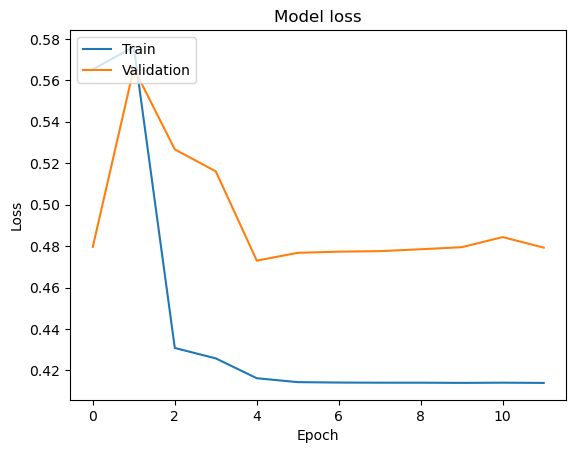

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_labels = np.round(y_pred)
cm = confusion_matrix(y_test, y_pred_labels)

In [ ]:
cm